In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
import pandas as pd
import random
from IPython.display import Audio, display
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
plt.style.use("seaborn-v0_8")
from sklearn.utils.class_weight import compute_class_weight

Found 8000 WAV files with labels
  wav/759808e5-f824-401e-9058.wav → 1
  wav/1d94fc4a-1c63-4da0-9cac.wav → 1
  wav/bb0099ce-3073-4613-8557.wav → 1
  wav/c4c67e81-9aa8-4af4-8eb7.wav → 1
  wav/ab322d4b-da69-4b06-a065.wav → 0

Label distribution:
hasbird
1    6045
0    1955
Name: count, dtype: int64


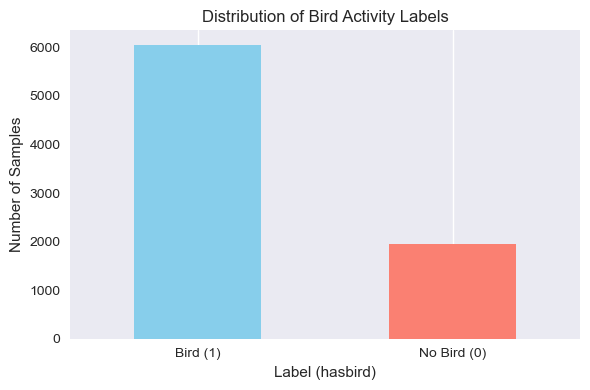

In [6]:
# 1. Load your metadata CSV
meta_df = pd.read_csv('warblrb10k_public_metadata_2018.csv')

# 2. Define the relevant columns
ID_COL    = 'itemid'   # base filename (without “.wav”)
LABEL_COL = 'hasbird'  # 0/1 bird‐activity flag
WAV_DIR   = Path('wav')

# 3. Build a full-path column and filter to existing files
meta_df['file_path'] = meta_df[ID_COL].apply(lambda x: WAV_DIR / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

# 4. Extract your two parallel lists
audio_files = meta_df['file_path'].astype(str).tolist()
labels      = meta_df[LABEL_COL].tolist()
labels = np.array(labels)  # ✅ Prepare for class weight

# 5. Sanity check
print(f"Found {len(audio_files)} WAV files with labels")
for path, lab in zip(audio_files[:5], labels[:5]):
    print(f"  {path} → {lab}")

# 6. Analyze labels distribution
label_counts = meta_df[LABEL_COL].value_counts()
print("\nLabel distribution:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Bird Activity Labels')
plt.xlabel('Label (hasbird)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Bird (1)', 'No Bird (0)'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [7]:
from tqdm import tqdm
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# --- Parameters ---
SR = 22050
DURATION = 10.0
TARGET_SAMPLES = int(SR * DURATION)
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 1024
FMAX = SR // 2

np.complex = complex  # compatibility fix for librosa

# --- Data augmentation ---
def augment_audio(y, sr):
    if random.random() < 0.5:
        shift = int(sr * random.uniform(-1.0, 1.0))
        y = np.roll(y, shift)

    if random.random() < 0.5:
        noise = np.random.normal(0, 0.005, len(y))
        y += noise

    if random.random() < 0.3:
        steps = random.randint(-2, 2)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=steps)

    if random.random() < 0.3:
        rate = random.uniform(0.8, 1.2)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * rate))

    return y

# --- Preprocessing function ---
def preprocess_file(fp, sr=SR, augment=False):
    y, _ = librosa.load(fp, sr=sr)

    if augment:
        y = augment_audio(y, sr=sr)

    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    if len(y) > TARGET_SAMPLES:
        y = y[:TARGET_SAMPLES]
    else:
        y = np.pad(y, (0, TARGET_SAMPLES - len(y)))

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                       hop_length=HOP_LENGTH, n_mels=N_MELS, fmax=FMAX)
    return librosa.power_to_db(S, ref=np.max)

# --- Load metadata and paths ---
meta_df = pd.read_csv("warblrb10k_public_metadata_2018.csv")
meta_df['file_path'] = meta_df['itemid'].apply(lambda x: Path("wav") / f"{x}.wav")
meta_df = meta_df[meta_df['file_path'].map(Path.exists)]

audio_files = meta_df['file_path'].astype(str).tolist()
labels = meta_df['hasbird'].tolist()

# --- Split: train / val / test ---
files_temp, files_test, y_temp, y_test = train_test_split(
    audio_files, labels, test_size=0.1, stratify=labels, random_state=42
)

val_frac = 0.2 / 0.9
files_train, files_val, y_train, y_val = train_test_split(
    files_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# --- Process datasets ---
def process_dataset(file_list, augment=False):
    return [preprocess_file(fp, augment=augment) for fp in tqdm(file_list, desc=f"Processing {'Train (aug)' if augment else 'Set'}")]

print("➡️  Preprocessing TRAIN set (with augmentation)...")
X_train = np.stack(process_dataset(files_train, augment=True))
y_train = np.array(y_train)

# ✅ Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights_array))
print(f"\n✅ Class weights: {class_weight_dict}")

print("➡️  Preprocessing VALIDATION set...")
X_val = np.stack(process_dataset(files_val, augment=False))
y_val = np.array(y_val)

print("➡️  Preprocessing TEST set...")
X_test = np.stack(process_dataset(files_test, augment=False))
y_test = np.array(y_test)

# --- Info ---
print(f"\n✅ Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

def label_distribution(y, name):
    c = Counter(y)
    print(f"{name} label distribution: {dict(c)}")

label_distribution(y_train, "Train")
label_distribution(y_val, "Validation")
label_distribution(y_test, "Test")


➡️  Preprocessing TRAIN set (with augmentation)...


Processing Train (aug): 100%|███████████████| 5600/5600 [02:57<00:00, 31.57it/s]



✅ Class weights: {0: 2.046783625730994, 1: 0.6616257088846881}
➡️  Preprocessing VALIDATION set...


Processing Set: 100%|███████████████████████| 1600/1600 [00:25<00:00, 63.52it/s]


➡️  Preprocessing TEST set...


Processing Set: 100%|█████████████████████████| 800/800 [00:14<00:00, 55.92it/s]


✅ Shapes:
X_train: (5600, 64, 216), y_train: (5600,)
X_val:   (1600, 64, 216), y_val:   (1600,)
X_test:  (800, 64, 216), y_test:  (800,)
Train label distribution: {1: 4232, 0: 1368}
Validation label distribution: {1: 1209, 0: 391}
Test label distribution: {0: 196, 1: 604}


In [8]:
X_train_rs = np.moveaxis(X_train, 1, -1)
X_val_rs = np.moveaxis(X_val, 1, -1)
X_test_rs = np.moveaxis(X_test, 1, -1)

X_train_rss = np.expand_dims(X_train_rs, axis=3)
X_val_rss = np.expand_dims(X_val_rs, axis=3)
X_test_rss = np.expand_dims(X_test_rs, axis=3)

print(f'Original size:\n X_train_rs.shape=', X_train_rs.shape, '\n X_val_rs.shape=', X_val_rs.shape, '\n X_test_rs.shape=', X_test_rs.shape)
print(f'\nNew size \n X_train_rss.shape=X_train_rss.shape', X_train_rss.shape, '\n X_val_rss.shape=', X_val_rss.shape, '\n X_test_rss.shape=', X_test_rss.shape)

input_shape = X_train_rss.shape[1:]  # e.g., (216, 1, 64)
print('Using input_shape =', input_shape)

model_hyb = Sequential([
    TimeDistributed(Conv1D(16, 9, activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(16, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Conv1D(32, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(2, padding='same')),
    TimeDistributed(Dropout(0.5)),

    TimeDistributed(Flatten()),

    LSTM(32, return_sequences=True),
    GlobalAveragePooling1D(),
    Dropout(0.35),

    Dense(1, activation='sigmoid')
])

model_hyb.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_hyb.summary()

Original size:
 X_train_rs.shape= (5600, 216, 64) 
 X_val_rs.shape= (1600, 216, 64) 
 X_test_rs.shape= (800, 216, 64)

New size 
 X_train_rss.shape=X_train_rss.shape (5600, 216, 64, 1) 
 X_val_rss.shape= (1600, 216, 64, 1) 
 X_test_rss.shape= (800, 216, 64, 1)
Using input_shape = (216, 64, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 216, 56, 16)       160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 216, 28, 16)       0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 216, 28, 16)       0         
 stributed)                                                      
                          

In [9]:
# 1. Set up callbacks
csv_logger = CSVLogger('Hybrid_CNN_RNN_BALANCED_training_log.csv', append=False)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'Hybrid_CNN_RNN_BALANCED_Classifier.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
callbacks_list = [csv_logger, early_stop, model_checkpoint]

# 2. Train with balanced class weightss
history = model_hyb.fit(
    X_train_rss, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_rss, y_val),
    callbacks=callbacks_list,
    class_weight=class_weight_dict,  # ✅ Balanced class training
    verbose=1
)


Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5336
Epoch 1: val_accuracy improved from -inf to 0.28750, saving model to Hybrid_CNN_RNN_BALANCED_Classifier.h5
175/175 [==============================] - 17s 91ms/step - loss: 0.6954 - accuracy: 0.5336 - val_loss: 0.7772 - val_accuracy: 0.2875
Epoch 2/100
  2/175 [..............................] - ETA: 14s - loss: 0.6946 - accuracy: 0.6562

/opt/miniconda3/envs/CMRM2024/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/175 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5334
Epoch 2: val_accuracy improved from 0.28750 to 0.66688, saving model to Hybrid_CNN_RNN_BALANCED_Classifier.h5
175/175 [==============================] - 16s 91ms/step - loss: 0.6913 - accuracy: 0.5334 - val_loss: 0.6742 - val_accuracy: 0.6669
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5377
Epoch 3: val_accuracy improved from 0.66688 to 0.75500, saving model to Hybrid_CNN_RNN_BALANCED_Classifier.h5
175/175 [==============================] - 16s 91ms/step - loss: 0.6889 - accuracy: 0.5377 - val_loss: 0.5420 - val_accuracy: 0.7550
Epoch 4/100
175/175 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5495
Epoch 4: val_accuracy did not improve from 0.75500
175/175 [==============================] - 16s 91ms/step - loss: 0.6821 - accuracy: 0.5495 - val_loss: 0.7487 - val_accuracy: 0.3650
Epoch 5/100
175/175 [==============================

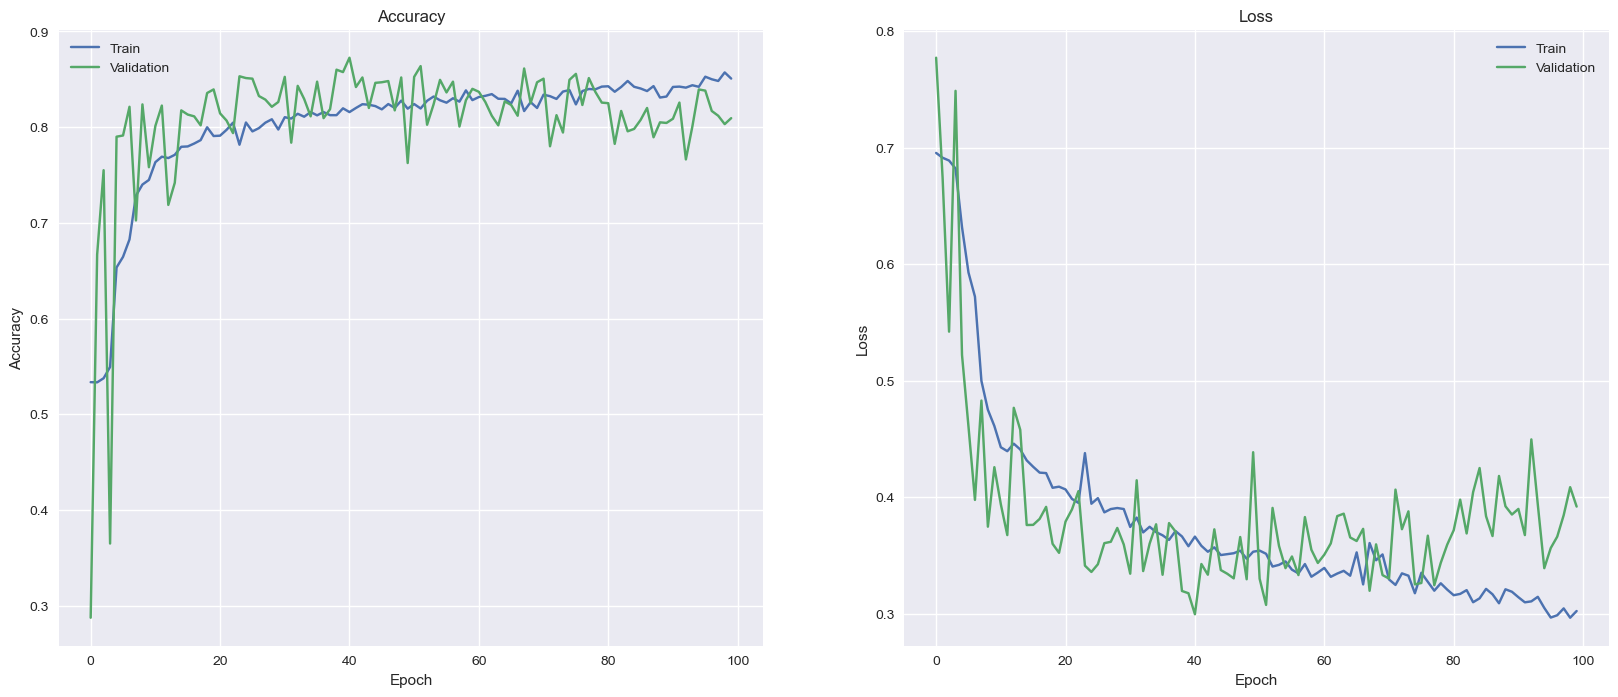

In [10]:
#Training history
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])


plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

50/50 [==============================] - 1s 22ms/step - loss: 0.2994 - accuracy: 0.8725
Validation accuracy: 0.8725, Validation loss: 0.2994
25/25 [==============================] - 1s 22ms/step - loss: 0.3235 - accuracy: 0.8438
Test accuracy: 0.8438, Test loss: 0.3235
50/50 [==============================] - 1s 21ms/step


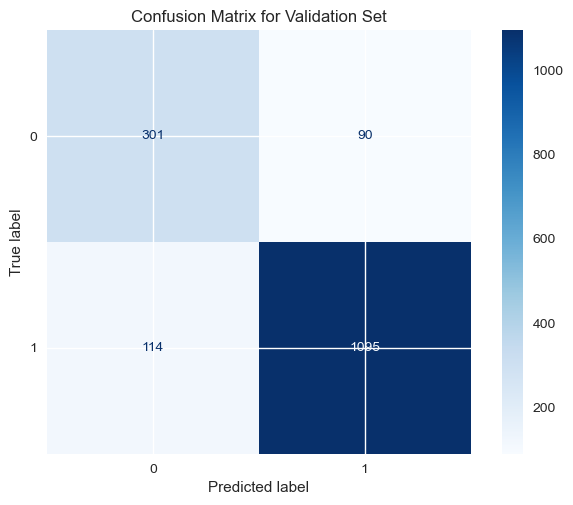

25/25 [==============================] - 1s 22ms/step


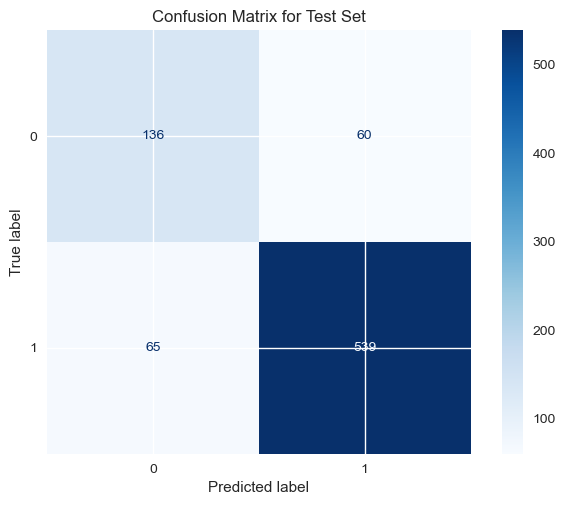

              precision    recall  f1-score   support

           0       0.73      0.77      0.75       391
           1       0.92      0.91      0.91      1209

    accuracy                           0.87      1600
   macro avg       0.82      0.84      0.83      1600
weighted avg       0.88      0.87      0.87      1600

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       196
           1       0.90      0.89      0.90       604

    accuracy                           0.84       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.85      0.84      0.84       800



In [11]:
#Optimal weights
model_hyb.load_weights('Hybrid_CNN_RNN_BALANCED_Classifier.h5')
val_loss, val_acc = model_hyb.evaluate(X_val_rss, y_val)
print(f'Validation accuracy: {val_acc:.4f}, Validation loss: {val_loss:.4f}')
test_loss, test_acc = model_hyb.evaluate(X_test_rss, y_test)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

#------- confusion matrices

# Validation set ---
# 1) Predict probabilities
y_prob_val = model_hyb.predict(X_val_rss)

# 2) Threshold at 0.5 to get binary predictions
y_pred_val = (y_prob_val.flatten() > 0.5).astype(int)

# 3) Compute & display
cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=[0, 1]
)
disp_val.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Set')
plt.show()


# Test set ---
y_prob_test = model_hyb.predict(X_test_rss)
y_pred_test = (y_prob_test.flatten() > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=[0, 1]
)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Set')
plt.show()

#---- classification reports
#Classification reports
print(classification_report(y_val, y_pred_val))
print(classification_report(y_test, y_pred_test))